In [29]:
#nltk.download('vader_lexicon')
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import re
import time
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import warnings

warnings.filterwarnings('ignore')

df = pd.read_csv("DF.csv")

for each in df.columns:

    print(str(each) + "-- " + str(df[each].isnull().sum()))

Unnamed: 0-- 0
id-- 0
gvkey-- 0
tic-- 0
name-- 0
sector-- 4
group-- 4062
industry-- 4062
sub_industry-- 4905
call_date-- 0
year-- 0
quarter-- 0
revenue-- 0
earnings-- 0
forecast-- 0
difference-- 0
title-- 0
text-- 0
sue1-- 3922
sue3-- 0
valid-- 0
summary-- 0
q_a-- 0
summary_score-- 254
q_a_score-- 28


In [15]:
iVarsTypesDict = ["c", "d", "d_refName"]

def patsyParse(dVar, iVars, iVarsTypes):
    
    funcformStr = dVar + " ~ "
    
    for index in range(len(iVars)): 
        
        varType = iVarsTypes[index]
        
        if varType == "c":
            
            funcformStr += iVars[index] + " + "
        
        elif varType == "d":
            
            funcformStr += "C(" + iVars[index] + ") + "
            
        else:
        
            _, refName = re.split(r"_", varType, maxsplit=1)
            funcformStr += "C(" + iVars[index] + ", Treatment(" + refName + ") + "
            
    return funcformStr[:len(funcformStr)-3]
        
def lag(df, colKey, lag):
    
    newColKey = colKey + str(lag)
    df[newColKey] = df[colKey].shift(lag)

def split(df, colName, newColNames, phrase):
    
    col = df[colName]
    newCols = [[],[]]
    
    for call in range(len(col)):
        
        splitList = col[call].split(phrase)
        newCols[0].append(splitList[0])
        newCols[1].append(splitList[1])
    
    df[newColNames[0]] = newCols[0]
    df[newColNames[1]] = newCols[1]

def genSentiment(df, colArray, alertInterval): #pass in alertInterval as seconds
    
    t0 = time.time()
    tCurr = t0
    
    analyzer = SentimentIntensityAnalyzer()
    
    for i in range(len(colArray)):
        
        currCol = df[colArray[i]]

        newColName = colArray[i] + "_score"
        
        df[newColName] = ""

        for j in range(len(df)):

            if time.time() - tCurr >= alertInterval:
                
                tCurr = time.time()
                print(str(np.round_(time.time()-t0,1)) + " seconds elapsed;" + str(j+1) + " iteration of " + str(i+1) + " column")

            score = analyzer.polarity_scores(currCol[j])
            neg = score['neg']
            pos = score['pos']
            
            if neg == 0:
                df[newColName][j] = None
            else:
                
                df[newColName][j] = pos/neg
                

In [ ]:

for i in ["summary_score", "q_a_score"]:
    lag(dft, i, 1)

The set $T = ${ $t_1,...,t_j$ }, where $t_i$ is a subgroup of the data, the set $L = ${ $l_1...l_n$ } where l_i is some lag

$d_t=\theta_{1j}+\begin{bmatrix}\theta_{2j}\\+\\...\\+\\\theta_{nj}\end{bmatrix}\begin{bmatrix}s_{\tau-1}+...+s_{\tau-n-1}\end{bmatrix}+\begin{bmatrix}\theta_{n+2}\\+\\...\\+\\\theta_{n+2+k}\end{bmatrix}\begin{bmatrix}c_{1}+...+c_{k+1}\end{bmatrix}+\epsilon$

where $n$ = number of sequential lags, $j$ = number of class groups, $k$ = number of control variables

for each $j$,

$\theta_{mj} = \alpha_m + \beta_{mj}\bar{s}_{\tau-i} + u_{mj}$, and $\theta_{1j} = \alpha_a + \beta_{1j} + u_{1j}$

where $m$ is some group $\in T$, $i$ is some lag $\in L$, $\bar{s}$ is a subset of s where $\bar{s}_i \in t_m \forall i$

In [32]:
import time
import requests
from bs4 import BeautifulSoup

def parseManualDictionary(dict): #returns as follows: trueList, falseList
    
    list1 = []
    list2 = []
    
    for word in dict:
        
        word = word.lower().strip(". ")
        
        if word[0] != "-":
            list1.append(word)
        
        else:
            list2.append(word[1:])
            
    list1 = set(list1)
    list2 = set(list2)
    
    return list1, list2


def synonyms(term):
    
    response = requests.get('https://www.thesaurus.com/browse/{}'.format(term))
    soup = BeautifulSoup(response.text, 'lxml')
    soup.find('section', {'class': 'css-17ofzyv e1ccqdb60'})
    return [span.text for span in soup.findAll('a', {'class': 'css-1kg1yv8 eh475bn0'})]

def getSynonyms(word, breadth, depth):
    
    currDepth = 0
    synQueue = [word]
    synArray = []

    while currDepth < (depth+1)*breadth:

        currDepth += 1

        currWord = synQueue.pop(0)
        currSyns = synonyms(currWord)[0:breadth]
        synQueue.extend(currSyns)
        synArray.append(currWord)


    while len(synQueue) > 0:

        currWord = synQueue.pop(0)

        currSyns = synonyms(currWord)[0:5]
        synArray.extend(currSyns)
    
    return set(synArray)


def computeScore(method, textColumn, dictPos, dictNeg):
    
    interval = 1000
    currInterval = 0
    currIteration = 0
    startIntervalTime = time.time()
    scoreArray = []
    n = len(textColumn)
    
    for text in textColumn:
        
        if type(text) == float:
            
            scoreArray.append(None)
            continue
        
        currInterval += 1
        currIteration += 1
        text = text.split()
        posCount = 0
        negCount = 0
        
        if currInterval == interval:
            
            print(str(currIteration) + " complete")
            print(round(time.time() - startIntervalTime))
            currInterval = 0            
        
        for word in text:
            
            if word in dictPos:
                
                posCount += 1
            
            elif word in dictNeg:
                
                negCount += 1
                
        
        score = method(posCount, negCount)
        scoreArray.append(score)
    
    return scoreArray
        
    
def method(i1, i2):
    
    if i2 != 0:
    
        return round(i1 / i2, 2)
    
    else:
        
        return np.Inf

In [ ]:
confPosSyns = getSynonyms("absolute", breadth=5, depth=2)
print("1/4 complete...")
confNegSyns = getSynonyms("uncertain", breadth=5, depth=2)
print("2/4 complete...")
sentPosSyns = getSynonyms("good", breadth=5, depth=2)
print("3/4 complete...")
sentNegSyns = getSynonyms("unfavorable", breadth=5, depth=2)
print("complete.")

confDictManual = np.genfromtxt("term_project/confidence_dict.txt",dtype="str")
sentDictManual = np.genfromtxt("term_project/sentiment_dict.txt",dtype="str")
confPosManual, confNegManual = parseManualDictionary(confDictManual)
sentPosManual, sentNegManual = parseManualDictionary(sentDictManual)

confPosFull = confPosSyns.union(confPosManual)
confNegFull = confNegSyns.union(confNegManual)
confPosFull = list(set(confPosFull))
confNegFull = list(set(confNegFull))

sentPosFull = sentPosSyns.union(sentPosManual)
sentNegFull = sentNegSyns.union(sentNegManual)
sentPosFull = list(set(sentPosFull))
sentNegFull = list(set(sentNegFull))

textColNames =  ["summary", "q_a"]
keyword = "Questions and Answers"

df["valid"] = ""

for i in range(len(df)):
    
    if type(df["text"][i]) == float:
        
        df["valid"][i] = False
        
    else:
    
        df["valid"][i] = keyword in df["text"][i]

df = df[df["valid"]==True]

df = df.reset_index(drop=True)

split(df, "text", textColNames, keyword)

genSentiment(df, textColNames, 10)

df['summary_conf'] = computeScore(method, df['summary'], confPosFull, confNegFull)
df['q_a_conf'] = computeScore(method, df['q_a'], confPosFull, confNegFull)

df['summary_sent'] = computeScore(method, df['summary'], sentPosFull, sentNegFull)
df['q_a_sent'] = computeScore(method, df['q_a'], sentPosFull, sentNegFull)

df.to_csv("DF.csv")




In [92]:
def cleanScores(col, colName):

    scores = col

    scores = pd.DataFrame(scores)

    scores = scores[scores[colName] != np.Inf]

    scores.dropna()

    return scores.to_numpy().flatten()

scoreNames = df.columns[len(df.columns)-4:]

scoreDict = {}

for each in scoreNames:

    scoreDict[each] = cleanScores(df[each], each)

<BarContainer object of 4 artists>

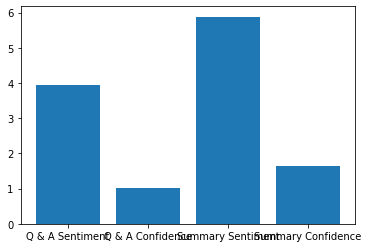

In [93]:
barData = {}

barData['Q & A Sentiment'] = np.mean(scoreDict['q_a_sent'])
barData['Q & A Confidence'] = np.mean(scoreDict['q_a_conf'])
barData['Summary Sentiment'] = np.mean(scoreDict['summary_sent'])
barData['Summary Confidence'] = np.mean(scoreDict['summary_conf'])

labs = list(barData.keys())
values = list(barData.values())

plt.bar(labs, values)


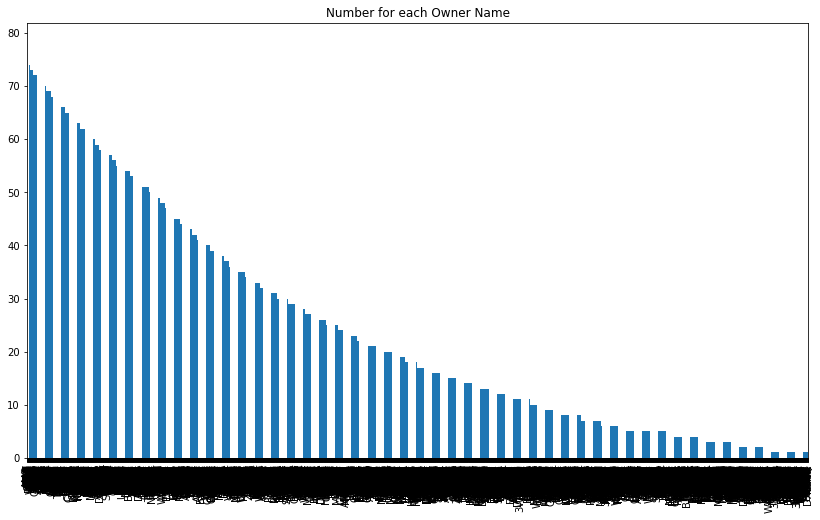

In [95]:
ax = df['tic'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Ticker Call Frequency")

In [53]:
counts = df['tic'].value_counts()

validTics = counts[counts >= 16].index

validTics = validTics.tolist()

df_hat = df[df['tic'].isin(validTics)]

df_hat = df_hat.drop(['summary','q_a', 'text', 'id', 'gvkey', 'title', 'name'], axis = 1)

df_hat = df_hat.reset_index(drop=True)

checkNans = ["q_a_score", "summary_score"]

for curr in checkNans:

    df_hat = df_hat[df_hat[curr].isna() == False]

    df_hat = df_hat.reset_index(drop=True)

In [55]:
checkNans = ["q_a_score", "summary_score", "industry", "sector"]

for curr in checkNans:

    df_hat = df_hat[df_hat[curr].isna() == False]

    df_hat = df_hat.reset_index(drop=True)

In [28]:
#pip install statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

# data = sm.datasets.get_rdataset("dietox", "geepack").data
# md = smf.mixedlm("Weight ~ Time", data, groups=data["Pig"])

features = ["summary_score", "q_a_score", "sector"]
featuresType = ["c","c","d"]

funcForm = patsyParse("difference", features, featuresType)

mixed_model = smf.mixedlm(funcForm, df_hat, groups=df_hat["tic"])

mdf = mixed_model.fit()

print(mdf.summary())

C:\Users\Tanner\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                      Mixed Linear Model Regression Results
Model:                     MixedLM         Dependent Variable:         difference 
No. Observations:          109609          Method:                     REML       
No. Groups:                2822            Scale:                      0.1168     
Min. group size:           15              Log-Likelihood:             -39335.1338
Max. group size:           78              Converged:                  Yes        
Mean group size:           38.8                                                   
----------------------------------------------------------------------------------
                                        Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------
Intercept                               -0.025    0.005 -4.684 0.000 -0.036 -0.015
C(sector)[T.Consumer Staples]            0.000    0.009  0.018 0.986 -0.018  0.019
C(sector)[T.Energy]        

In [59]:
df_hat.to_csv("term_project/DF2_cleaned.csv")

In [36]:
textfile = open("sentNeg.txt", "w")
for element in sentNegSyns:
    textfile.write(element + "\n")
textfile.close()

In [50]:
confDictManual = np.genfromtxt("term_project/confidence_dict.txt",dtype="str")
sentDictManual = np.genfromtxt("term_project/sentiment_dict.txt",dtype="str")
confPosManual, confNegManual = parseManualDictionary(confDictManual)
sentPosManual, sentNegManual = parseManualDictionary(sentDictManual)

confPosFull = confPosSyns.union(confPosManual)
confNegFull = confNegSyns.union(confNegManual)
confPosFull = list(set(confPosFull))
confNegFull = list(set(confNegFull))

sentPosFull = sentPosSyns.union(sentPosManual)
sentNegFull = sentNegSyns.union(sentNegManual)
sentPosFull = list(set(sentPosFull))
sentNegFull = list(set(sentNegFull))

In [49]:
confPosSyns = set(confPosSyns)
confNegSyns = set(confNegSyns)

In [42]:
confNegSyns = ["mixed ", "incongruous ", "slightly", "insufficient ", "thinking", "exceptional ", "likely", "antagonistic ", "cryptic ", "inconceivable ", "dingy ", "mystifying ", "conceivable ", "boring ", "irreconcilable ", "baffling ", "sign", "faulty ", "trying", "afraid ", "discordant ", "hesitant ", "intend", "sense", "labored ", "said", "diverse ", "pretty", "somewhat", "frightened ", "anxious ", "partially", "wishy-washy ", "odd ", "inconsistent ", "allergic ", "indecisive ", "implausible ", "simple ", "erratic ", "maybe", "complicated ", "problematic ", "convoluted ", "arcane ", "believe", "deceptive ", "muddled ", "flimsy ", "slow ", "freakish ", "heard", "ticklish ", "seem", "contrary ", "stumbling ", "cagey ", "tricky ", "roughly", "slight", "doubtful ", "varied ", "sometimes", "try", "antithetical ", "incomplete ", "fuzzy ", "scared ", "dim ", "appears", "looking", "clashing ", "incomprehensible ", "esoteric ", "illogical ", "jumbled ", "tried", "unpredictable ", "please", "frivolous ", "debatable ", "dubious ", "defensible ", "arbitrary ", "tentative ", "estimate", "contradictory ", "hopefully", "predict", "dicey ", "flighty ", "inadequate ", "averse ", "curious ", "incompatible ", "clumsy ", "typically", "perhaps", "blurred ", "misleading ", "anomalous ", "implied", "broader", "enigmatic ", "anticipated", "impaired ", "could", "uncertain ", "hazy ", "blended ", "incorrect", "contentious ", "unbelievable ", "conflicting ", "obscure ", "dull ", "think", "imaginable ", "bizarre ", "adverse ", "comical ", "depends", "referring", "indiscernible", "false ", "blurry ", "fragmentary ", "impenetrable ", "dark ", "questionable ", "whatever", "different ", "nervous ", "equivocal ", "extraordinary ", "clouded ", "halting ", "potentially", "disorganized ", "hostile ", "almost", "fishy ", "cloudy ", "fantastic ", "awkward ", "ambiguous ", "idiosyncratic ", "usually", "funny ", "arguable ", "aberrant ", "apprehensive ", "defective ", "expect", "lacking ", "confusing ", "inconclusive ", "potential", "discretionary ", "opaque ", "careless ", "deficient ", "dumb ", "capricious ", "ambivalent ", "inaccurate", "inappropriate ", "moot ", "modest", "relative", "anticipate", "loath ", "fickle ", "flawed ", "chaotic ", "uncertainties", "evasive ", "uncertain", "broad", "atypical "]

In [52]:
df['summary_conf'] = computeScore(method, df['summary'], confPosFull, confNegFull)
df['q_a_conf'] = computeScore(method, df['q_a'], confPosFull, confNegFull)

df['summary_sent'] = computeScore(method, df['summary'], sentPosFull, sentNegFull)
df['q_a_sent'] = computeScore(method, df['q_a'], sentPosFull, sentNegFull)

df.to_csv("DF2.csv")

25000 complete
779
26000 complete
838
27000 complete
892
28000 complete
947
29000 complete
1006
30000 complete
1062
31000 complete
1117
32000 complete
1181
33000 complete
1246
34000 complete
1334
35000 complete
1403
36000 complete
1460
37000 complete
1521
38000 complete
1574
39000 complete
1630
40000 complete
1685
41000 complete
1738
42000 complete
1793
43000 complete
1856
44000 complete
1912
45000 complete
1967
46000 complete
2019
47000 complete
2067
48000 complete
2117
49000 complete
2163
50000 complete
2210
51000 complete
2260
52000 complete
2313
53000 complete
2366
54000 complete
2419
55000 complete
2473
56000 complete
2525
57000 complete
2582
58000 complete
2632
59000 complete
2692
60000 complete
2743
61000 complete
2792
62000 complete
2845
63000 complete
2903
64000 complete
2957
65000 complete
3016
66000 complete
3071
67000 complete
3131
68000 complete
3184
69000 complete
3236
70000 complete
3299
71000 complete
3352
72000 complete
3412
73000 complete
3470
74000 complete
3523
7500

In [60]:
df_hat

,Unnamed: 0,tic,sector,group,industry,sub_industry,call_date,year,quarter,revenue,...,difference,sue1,sue3,valid,summary_score,q_a_score,summary_conf,q_a_conf,summary_sent,q_a_sent
0,0,AIR,Industrials,Capital Goods,Aerospace & Defense,Aerospace & Defense,2009-12-16,2010,2,454.858,...,0.09,0.002850,0.003664,True,8.947368,6.772727,2.83,0.51,6.62,3.67
1,1,AIR,Industrials,Capital Goods,Aerospace & Defense,Aerospace & Defense,2010-12-16,2011,2,481.957,...,-0.02,0.000548,-0.001095,True,8.277778,5.370370,0.79,0.70,7.27,3.32
2,2,AIR,Industrials,Capital Goods,Aerospace & Defense,Aerospace & Defense,2011-12-16,2012,2,512.800,...,0.03,0.000651,0.001953,True,6.142857,7.304348,0.79,0.61,5.64,3.93
3,3,AIR,Industrials,Capital Goods,Aerospace & Defense,Aerospace & Defense,2004-12-17,2005,2,212.879,...,0.02,0.003343,0.000955,True,12.642857,4.296296,1.88,0.75,8.40,3.71
4,4,AIR,Industrials,Capital Goods,Aerospace & Defense,Aerospace & Defense,2008-12-17,2009,2,309.239,...,0.04,0.002144,0.002144,True,3.405405,5.107143,4.67,0.45,4.60,3.53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109604,129908,ALLE,Industrials,Capital Goods,Building Products,Building Products,2018-07-26,2018,2,704.700,...,0.07,0.001163,0.000905,True,13.916667,4.925926,2.17,0.56,11.24,2.33
109605,129909,ALLE,Industrials,Capital Goods,Building Products,Building Products,2017-07-27,2017,2,627.000,...,0.11,0.001479,0.001356,True,18.416667,7.285714,4.40,0.75,7.67,3.65
109606,129910,ALLE,Industrials,Capital Goods,Building Products,Building Products,2016-07-28,2016,2,584.900,...,0.08,0.004609,0.001152,True,16.818182,7.791667,1.05,0.58,7.91,3.62
109607,129911,ALLE,Industrials,Capital Goods,Building Products,Building Products,2015-07-30,2015,2,519.500,...,0.00,0.002162,0.000000,True,7.384615,9.631579,4.33,0.99,5.77,4.58
